# Planejamento da solução

1. Explorar os Dados usando ferramentas e testes Estatísticos com o objetivo de encontrar inconsistências dos dados e tratar possíveis dados faltantes.
2. Levantar Hipóteses sobre as características de transações legítimas e fraudulentas, validando ou refutando essas hipóteses através dos dados.
3. Preparar os Dados para que os Algoritmos de Machine Learning sejam capazes de aprender a tarefa.
4. Treinar e avaliar vários algoritmos Classificadores.
5. Contabilizar a Performance do Modelo de Machine Learning e transformar em Performance de Negócio.
6. Desenvolver uma API que retorne “Fraude” ou “Legítima” quando receber como entrada uma transação.

# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display    import display, HTML
from sklearn import metrics as m
from sklearn.model_selection import StratifiedKFold

## 0.1 Helper Functions

In [58]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 9]
    plt.rcParams['font.size'] = 24
    plt.rcParams["patch.force_edgecolor"] = True
    plt.rcParams['patch.edgecolor'] = 'black'
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    warnings.filterwarnings('ignore')
    sns.set()
    
jupyter_settings()

def cross_validation(model_name, model, x, y):
    
    x = x.to_numpy()
    y = y.to_numpy()
    
    
    balanced_accuracy = []
    precision = []
    recall = []
    f1 = []
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, test_index in skf.split(x, y):
        x_train_cv, x_test_cv = x[train_index], x[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
        
        
        model.fit(x_train_cv, y_train_cv)
        pred = model.predict(x_test_cv)

        balanced_accuracy.append(m.balanced_accuracy_score(y_test_cv, pred))
        precision.append(m.precision_score(y_test_cv, pred))
        recall.append(m.recall_score(y_test_cv, pred))
        f1.append(m.f1_score(y_test_cv, pred))

    
    acurracy_mean, acurracy_std = np.round(np.mean(balanced_accuracy), 2), np.round(np.std(balanced_accuracy),2)
    precision_mean, precision_std = np.round(np.mean(precision),2), np.round(np.std(precision),2)
    recall_mean, recall_std = np.round(np.mean(recall),2), np.round(np.std(recall),2)
    f1_mean, f1_std = np.round(np.mean(f1),2), np.round(np.std(f1),2)
    
    
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(acurracy_mean, acurracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std)}, index=[model_name])

def ml_metrics(model_name, y_true, pred):
    
    accuracy = m.balanced_accuracy_score(y_true, pred)
    precision = m.precision_score(y_true, pred)
    recall = m.recall_score(y_true, pred)
    f1 = m.f1_score(y_true, pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 2), 
                         'Precision': np.round(precision, 2), 
                         'Recall': np.round(recall, 2),
                         'F1': np.round(f1, 2)}, index=[model_name])


def frequency_encoding(df, column):
    encoder = df.groupby(column).size()/len(df)
    return encoder

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [3]:
df_raw = pd.read_csv('../data/fraud_detection-dataset.csv', low_memory=False)

In [4]:
df_raw.drop(columns='Unnamed: 0', inplace=True)

In [5]:
df_raw.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,isFraud
0,353,CASH_OUT,150540.160,C1389413404,9912.000,0.000,C819390946,29817.590,180357.750,0,0
1,282,CASH_OUT,66723.640,C958468196,0.000,0.000,C257205272,1136277.810,1203001.450,0,0
2,228,TRANSFER,1039375.010,C857481806,2328.000,0.000,C134214261,437583.330,1476958.340,0,0
3,36,PAYMENT,9178.610,C558963849,96237.620,87059.010,M635090135,0.000,0.000,0,0
4,48,PAYMENT,4527.240,C1644082954,51925.000,47397.760,M332145827,0.000,0.000,0,0


# 1.0 Data Description

In [6]:
df1 = df_raw.copy()

- **step** - mapeia uma unidade de tempo no mundo real. Neste caso, 1 etapa corresponde a 1 hora de tempo. Total de etapas 744 (simulação de 30 dias).

- **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- **amount** - valor da transação em moeda local.

- **nameOrig** - cliente que iniciou a transação

- **oldbalanceOrg** - saldo inicial antes da transação

- **newbalanceOrig** - saldo após a transação

- **nameDest** - cliente que é o destinatário da transação

- **oldbalanceDest** - destinatário do saldo inicial antes da transação. Observe que não há informações para clientes que começam com M (Merchants).

- **newbalanceDest** - novo destinatário do saldo após a transação. Observe que não há informações para clientes que começam com  M (Merchants).

- **isFraud** - São as transações feitas pelos agentes fraudulentos dentro da simulação. Neste conjunto de dados específico, o comportamento fraudulento dos agentes visa lucrar ao assumir o controle das contas dos clientes e tentar esvaziar os fundos transferindo para outra conta e retirando do sistema.

- **isFlaggedFraud** - O modelo de negócios visa controlar as transferências em massa de uma conta para outra e sinaliza tentativas ilegais. Uma tentativa ilegal neste conjunto de dados é uma tentativa de transferir mais de 200.000 em uma única transação.

## 1.1 Data Dimensions

In [7]:
df1.shape

(636262, 11)

## 1.2 Rename Columns

In [8]:
cols_new = ['step', 'type', 'amount', 'name_orig', 'old_balance_org', 'new_balance_orig',
       'name_dest', 'old_balance_dest', 'new_balance_dest', 'is_flagged_fraud',
       'is_fraud']

df1.columns = cols_new

## 1.3 Data Types

In [9]:
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
old_balance_org     float64
new_balance_orig    float64
name_dest            object
old_balance_dest    float64
new_balance_dest    float64
is_flagged_fraud      int64
is_fraud              int64
dtype: object

## 1.4 Check Na

In [10]:
df1.isna().sum()

step                0
type                0
amount              0
name_orig           0
old_balance_org     0
new_balance_orig    0
name_dest           0
old_balance_dest    0
new_balance_dest    0
is_flagged_fraud    0
is_fraud            0
dtype: int64

## 1.5 Fillout Na

There are not Nan values in the dataset

## 1.6 Change Types

In [11]:
df1['is_flagged_fraud'] = df1['is_flagged_fraud'].astype('int8')
df1['is_fraud'] = df1['is_fraud'].astype('int8')
df1['step'] = df1['step'].astype('int16')

## 1.7 Descriptive Statistical

### 1.7.1 Numerical Atributes

In [12]:
# Central tendecy - mean, median
# Dispersion - std, min, max, skew, kurtosis
skew = df1.skew()
kurtosis = df1.kurtosis()

In [13]:
metrics = pd.DataFrame(df1.describe().drop(['count','25%','75%']).T)
metrics = pd.concat([metrics, skew, kurtosis], axis=1)
metrics.columns = ['Mean','STD','Min','Median','Max',' Skew','Kurtosis']
metrics

,Mean,STD,Min,Median,Max,Skew,Kurtosis
step,243.602,142.398,1.000,241.000,743.000,0.369,0.316
amount,180035.707,600588.416,0.000,74896.380,69886731.300,30.744,1757.616
old_balance_org,838195.682,2900800.457,0.000,14057.340,59585040.370,5.248,33.096
new_balance_orig,859357.665,2935834.207,0.000,0.000,49585040.370,5.172,32.038
old_balance_dest,1106841.080,3486732.494,0.000,132774.340,355381433.610,21.979,1164.214
new_balance_dest,1230661.224,3754355.690,0.000,215337.580,355380483.530,21.226,1048.217
is_flagged_fraud,0.000,0.003,0.000,0.000,1.000,398.827,159061.750
is_fraud,0.001,0.036,0.000,0.000,1.000,27.785,769.992


### 1.7.2 Categorical Atributes

In [14]:
cat_attributes = df1.select_dtypes(include=['object'])
cat_attributes.apply(lambda x: x.unique().shape[0])

type              5
name_orig    636170
name_dest    457297
dtype: int64

In [15]:
cat_attributes.describe()

,type,name_orig,name_dest
count,636262,636262,636262
unique,5,636170,457297
top,CASH_OUT,C614361611,C248609774
freq,223667,2,16


# 2.0 feature Engineering

In [16]:
df2 = df1.copy()

## 2.1 Feature creation

In [17]:
# create column turning step into days
df2['days'] = df2['step'].apply(lambda x:  x/24 if x > 24 else 1)

# calculate difference between new balance and old balance ( orig and destination)
df2['dif_balance_orig'] =   df2['new_balance_orig'] - df2['old_balance_org']
df2['dif_balance_dest'] = df2['new_balance_dest'] -  df2['old_balance_dest'] 

## 2.2 Hypotheses List

H1. Valores de transação maiores de 10 milhões possuem uma média maior de fruades.

H2. Operações do tipo CASH OUT tem em média 20% mais fraudes.

H3. Operações realizadas nos 15 primeiros dias tem em media mais fraudes.

H4. Clientes que realizam alguma opção de retirada de dinheiro da conta (CASH OUT, TRANSFER) e possuem saldo menor do que o valor retirado possuem em média um maior número de fraudes.

H5. Clientes de destino que tinham saldo 0 e após uma transferência continuaram com saldo 0 tem em média 30% a mais de fraudes

# 3.0 Variable Filtering

In [18]:
df3 = df2.copy()

In [19]:
#df3.drop(columns=['name_orig', 'name_dest'], axis=1, inplace=True)

# 4.0 EDA

In [20]:
df4 = df3.copy()

### Pandas Profiling

In [21]:
from pandas_profiling import ProfileReport

In [22]:
#report = ProfileReport(df4, title='Pandas Profiling Report')

In [23]:
#report.to_file('report.html')

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

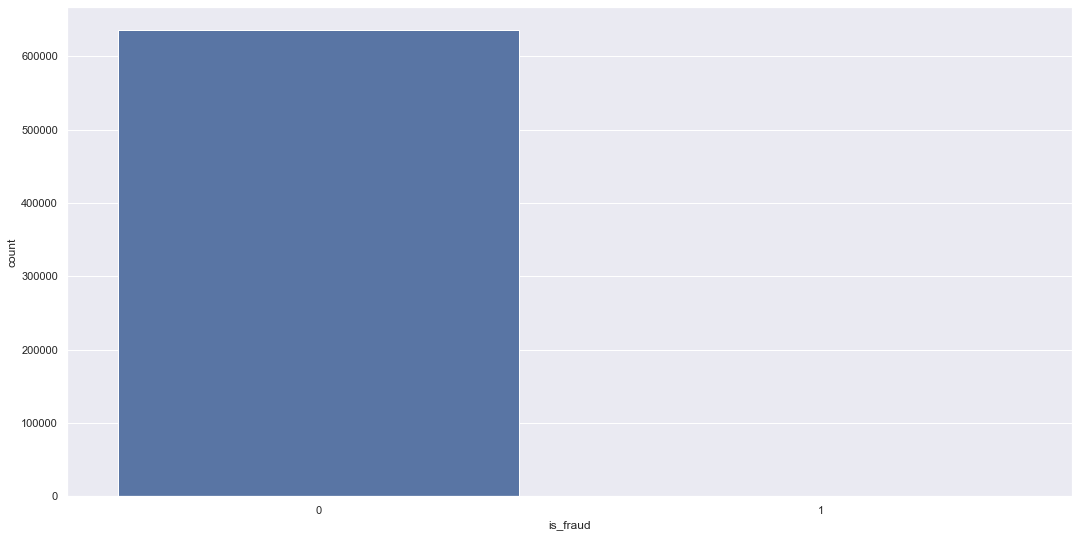

In [24]:
sns.countplot(df4['is_fraud']);

Como é perceptível a classe target é extremamente desbalanceada, os devidos tratamentos, se necessários, serão feitos em etapas futuras


### 4.1.2 Numerical variables

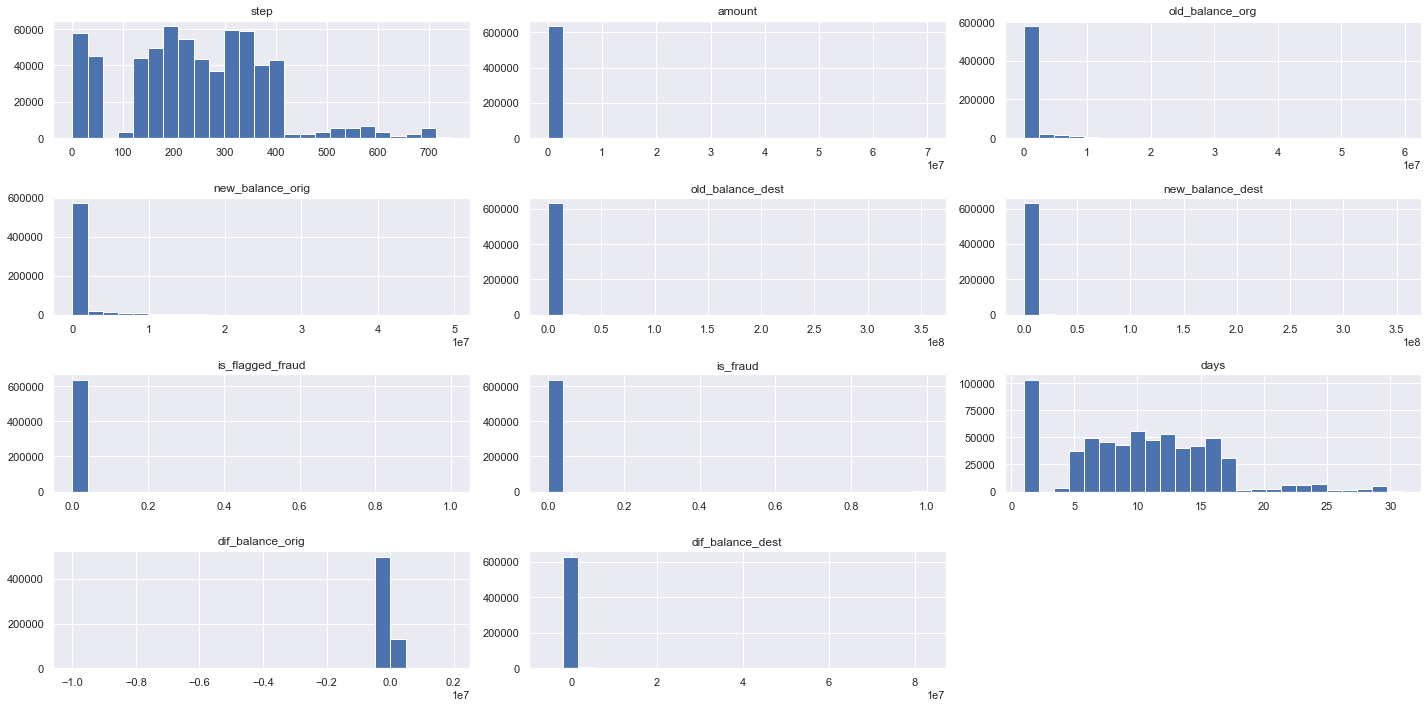

In [25]:
num_atributes = df4.select_dtypes(exclude='object')
num_atributes.hist(figsize=(20,10), bins=25);
plt.tight_layout()

<AxesSubplot:xlabel='amount'>

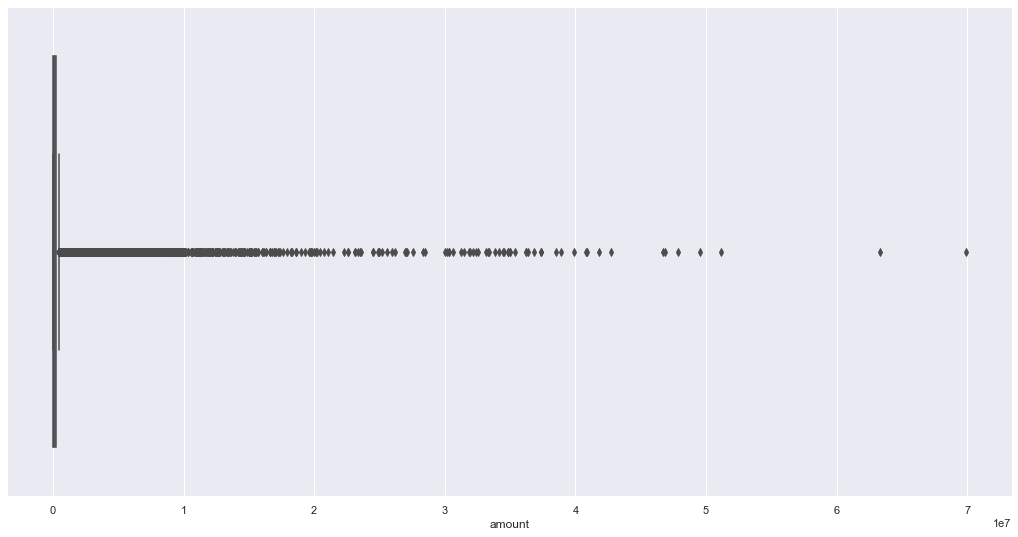

In [26]:
# amount - verificar valores acima de 52 milhoes
sns.boxplot(df4['amount'])

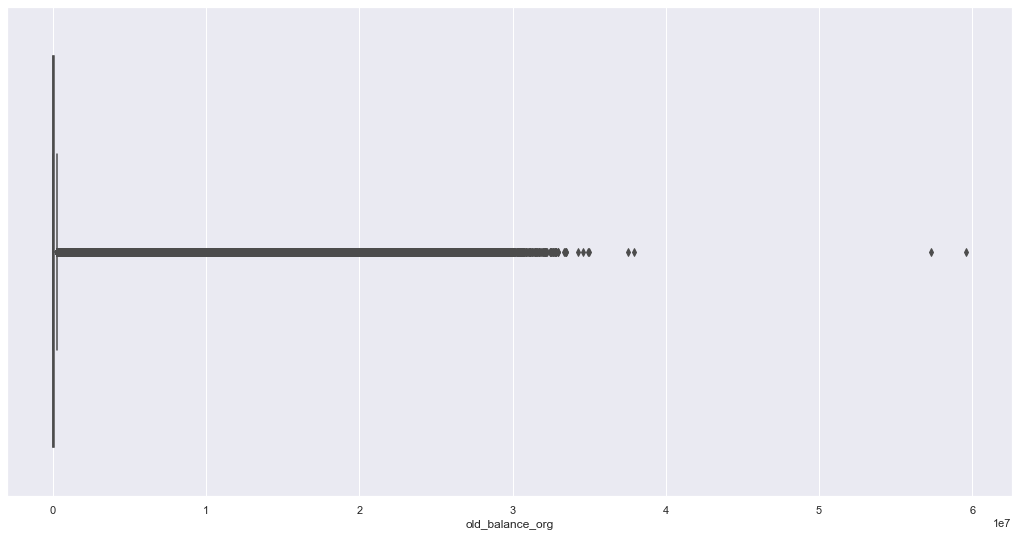

In [27]:
# old balance org 
sns.boxplot(df4['old_balance_org']);

Os dois valores acima de 38 milhões foram detectados como fraude

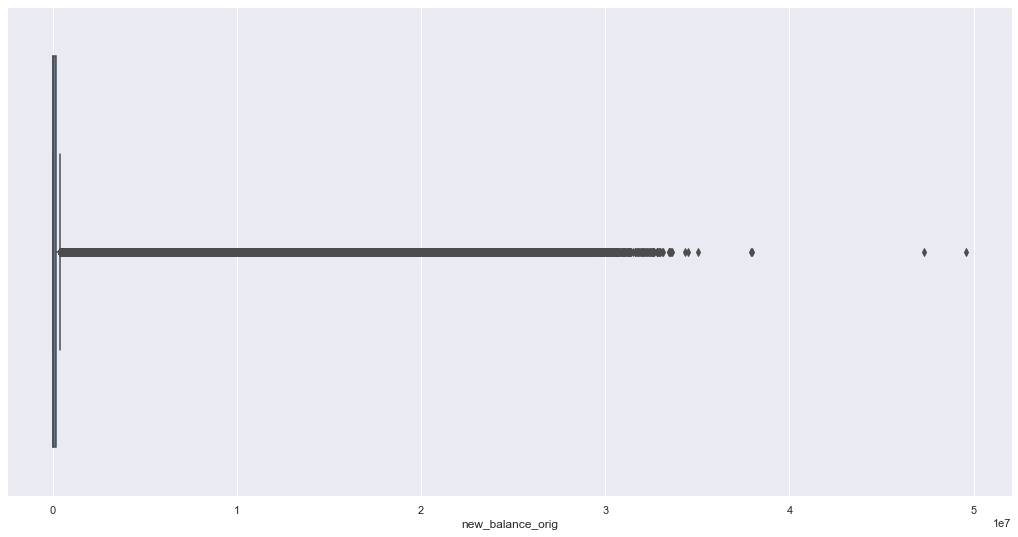

In [28]:
# new balance org 
sns.boxplot(df4['new_balance_orig']);

Os dois valores acima de 38 milhoes foram detectados como fraude

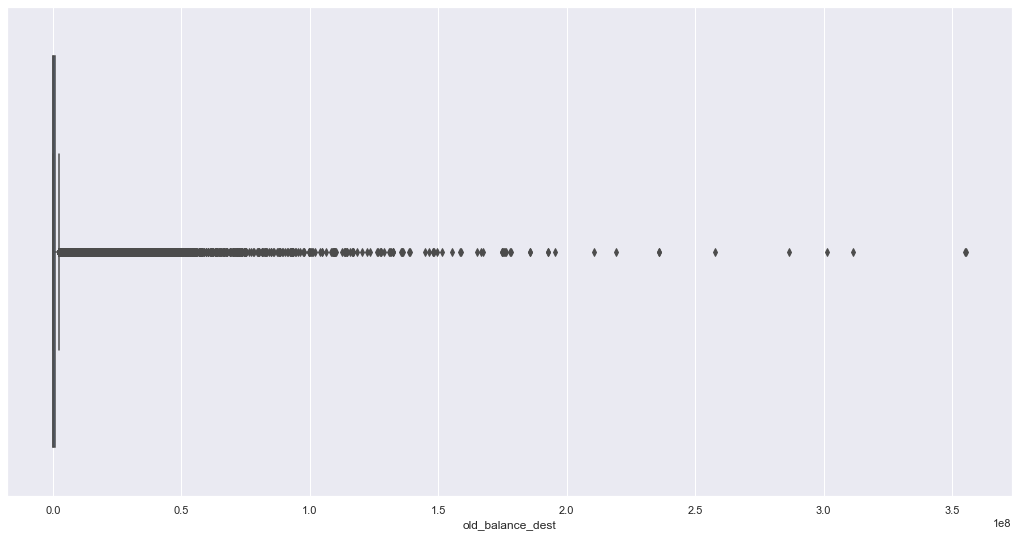

In [29]:
# old balance dest
sns.boxplot(df4['old_balance_dest']);

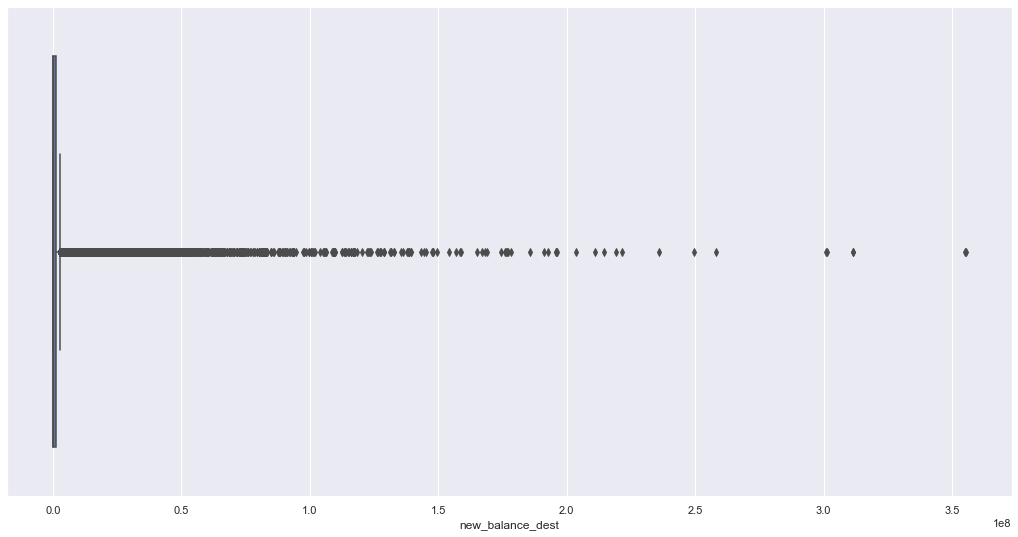

In [30]:
# new balance dest
sns.boxplot(df4['new_balance_dest']);

- Após uma melhor exploração dos dados, verifocu-se que os atrbutos old balance dest, new balance dest e old balance org possuem valores zeros na maioria dos casos de fraude, o que pode indicar alguma tendência de comportamento nesses casos.

### 4.1.3 Categorical Variables

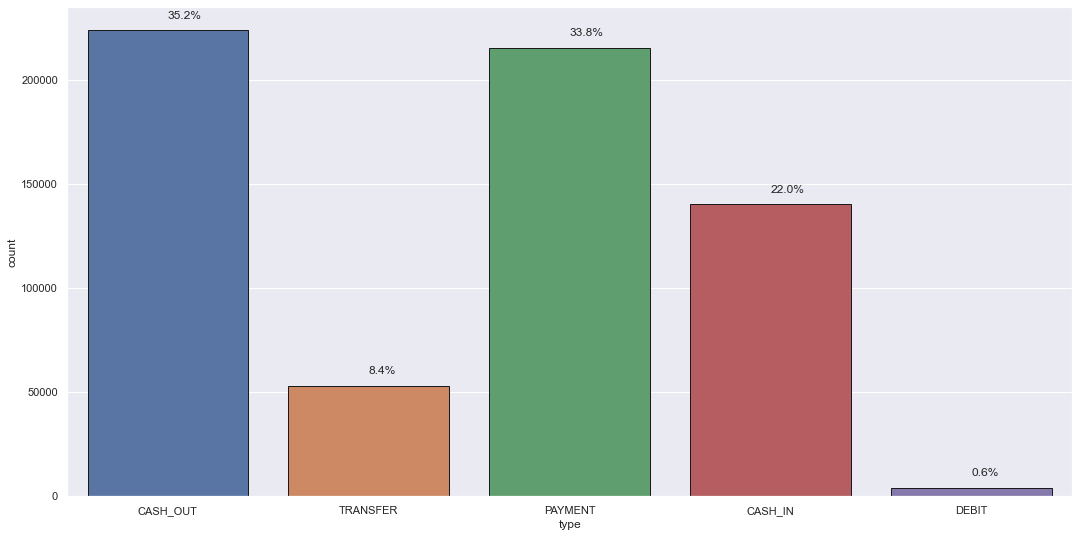

In [89]:
ax = sns.countplot(df4['type'], edgecolor='k');

total = len(df4)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y))

## 4.2 Bivariate Analysis

### H1. Valores de transações maiores de 2 milhões possuem em média 10% mais fruades.
**Falsa** - Valores de transações menores de 2 milhões possuem 50% a mais de fraudes

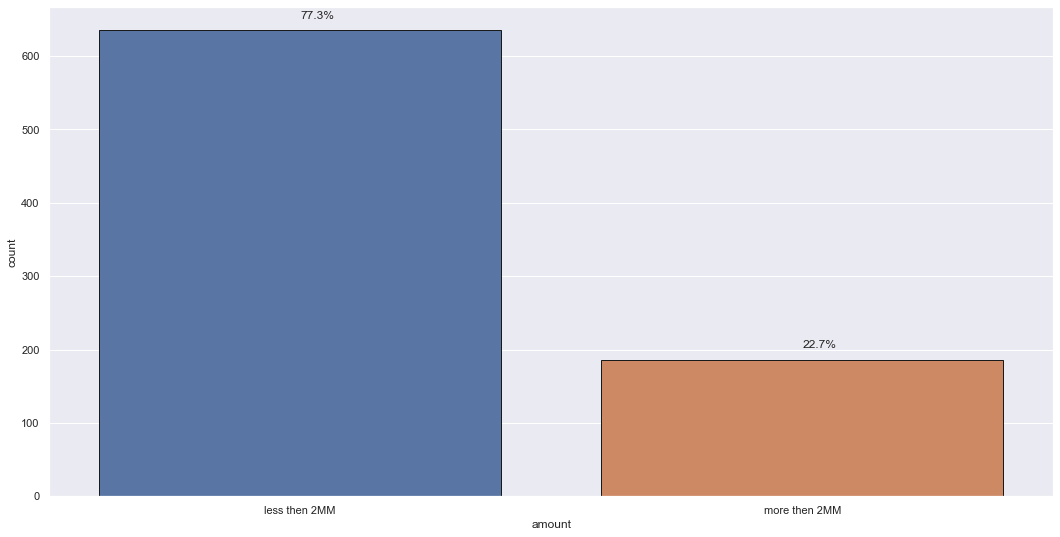

In [80]:
aux = df4.loc[df4['is_fraud'] == 1].copy()
aux['amount'] = aux['amount'].apply(lambda x: 'more then 2MM' if x > 2000000 else 'less then 2MM')
ax = sns.countplot(aux['amount'], edgecolor='k');

total = len(aux)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y))

### H2. Operações do tipo CASH OUT tem em média 20% mais fraudes.
**Falsa** - Operações do tipo CASH OUT possuem 3% a mais de fraudes. Obs: Apenas operações do tipo TRANSFER e CASH OUT possuem casos de fraude.

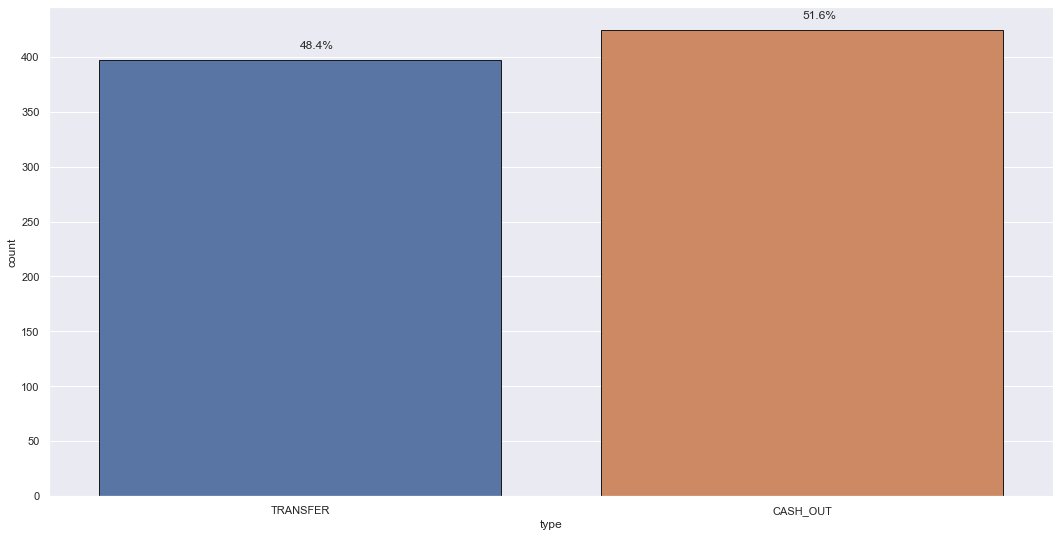

In [82]:
aux = df4.loc[df4['is_fraud'] == 1].copy()
ax = sns.countplot(aux['type'], edgecolor='k');

total = len(aux)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y))

É possível notar que todas as fraudes ocorreram apenas com esses dois tipos de operação 

### H3. Operações realizadas nos 15 primeiros dias tem em media 30% mais fraudes.
**Falsa** - Operações realizadas nos 15 primeiros dias possuem o mesmo número de fraudes das operações realizadas nos ultimos 15 dias.

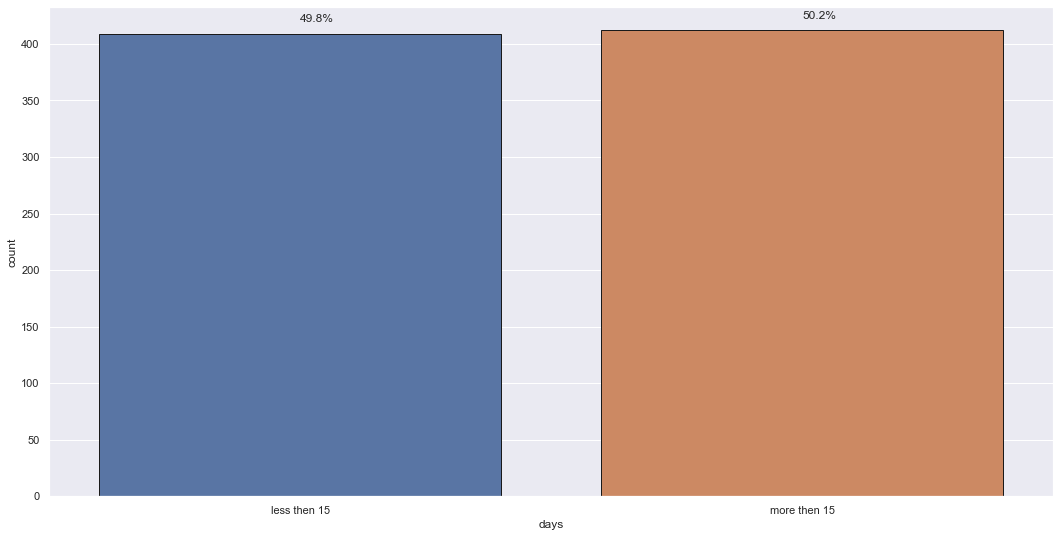

In [133]:
aux = df4.loc[df4['is_fraud'] == 1].copy()
aux['days'] = aux['days'].apply(lambda x: 'more then 15' if x > 15 else 'less then 15')
ax = sns.countplot(aux['days'], edgecolor='k');

total = len(aux)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y))

### H4. Clientes que realizam alguma opção de retirada de dinheiro da conta (CASH OUT, TRANSFER) e possuem saldo menor do que o valor retirado possuem em média um maior número de fraudes.
**Falsa** - Clientes que realizam alguma opção de retirada de dinheiro da conta (CASH OUT, TRANSFER) e possuem saldo menor do que o valor retirado possuem menos ocorrencias de fraude.

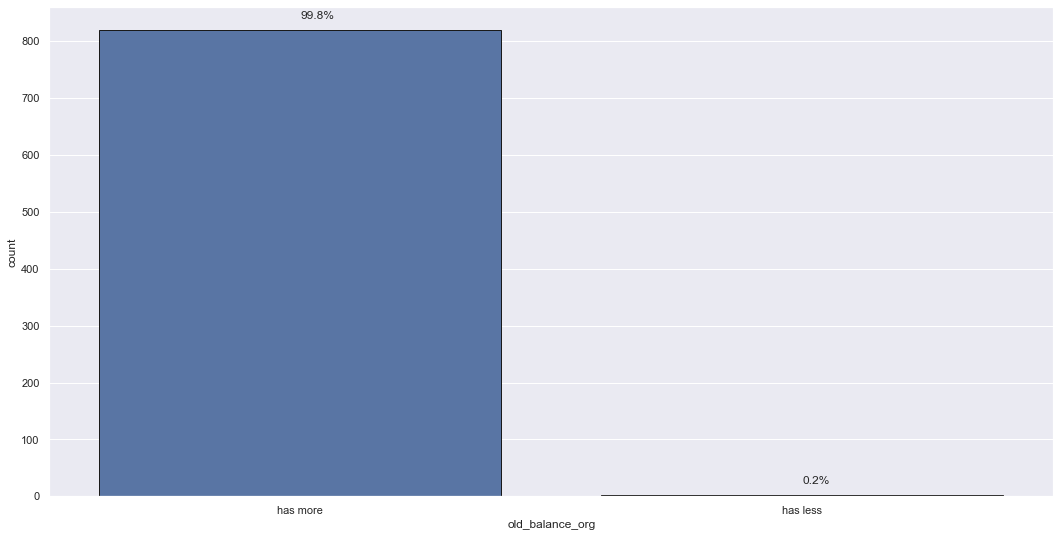

In [135]:
aux = df4.loc[df4['is_fraud'] == 1].copy()
aux['old_balance_org'] = aux[['old_balance_org','amount']].apply(lambda x: 'has more' if x['amount'] <= x['old_balance_org'] else 'has less', axis=1)
ax = sns.countplot(aux['old_balance_org'], edgecolor='k')

total = len(aux)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y))

### H5. Clientes de destino que tinham saldo 0 e após uma transferência continuaram com saldo 0 tem em média 30% a mais de fraudes
**Falsa** - Clientes de destino que tinham saldo 0 e após uma transferência continuaram com saldo 0 tem em média 3% menos fraudes

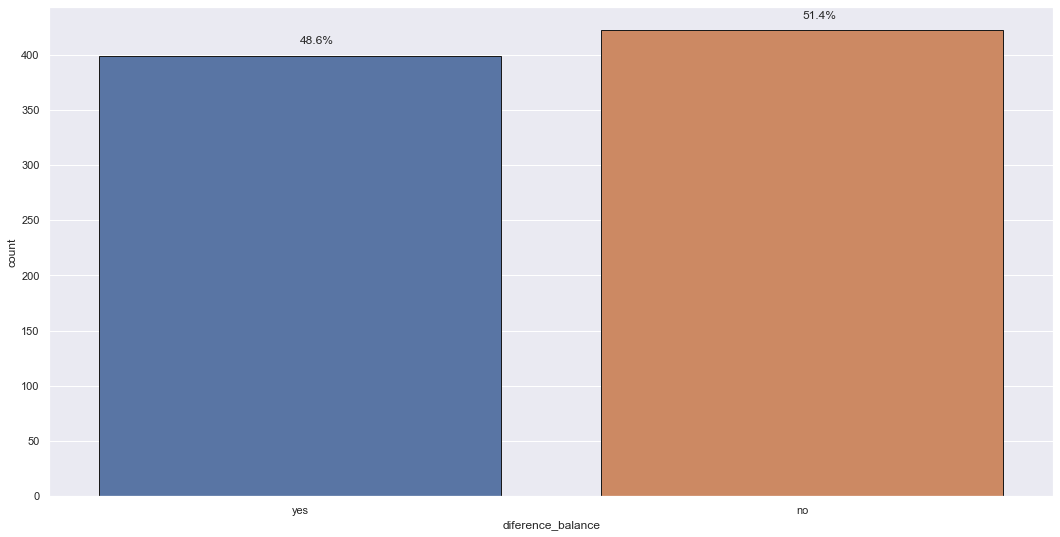

In [115]:
aux = df4.loc[df4['is_fraud'] == 1].copy()
aux['diference_balance'] = aux[['old_balance_dest','new_balance_dest']].apply(lambda x: 'yes' if (x['old_balance_dest'] == 0) & (x['new_balance_dest'] == 0) else 'no', axis=1)
ax = sns.countplot(aux['diference_balance'], edgecolor='k')
total = len(aux)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y))

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Atributes

<AxesSubplot:>

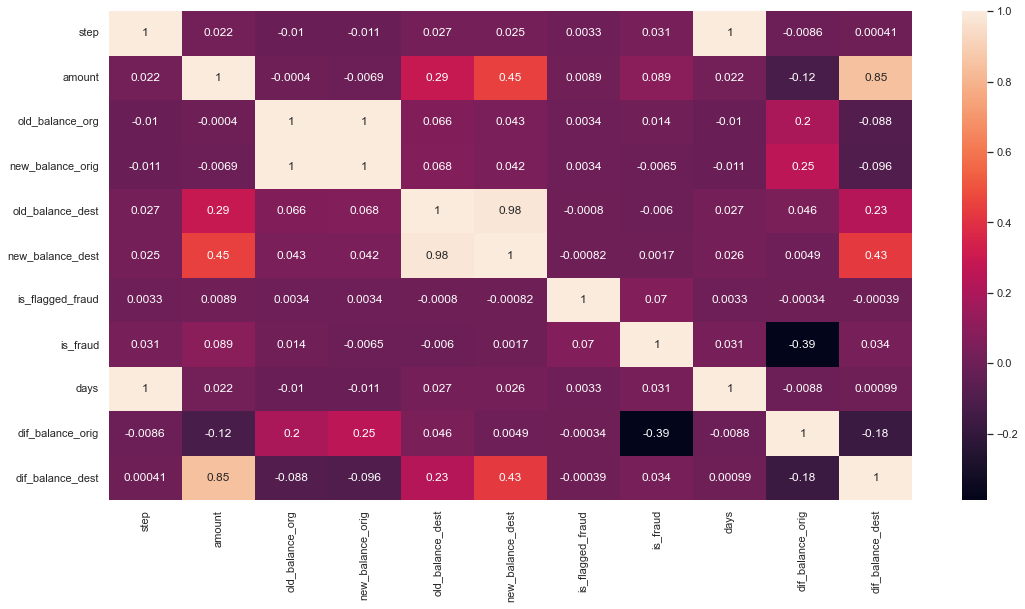

In [121]:
correlation = num_atributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

# 5.0 Data Preparation

In [32]:
df5 = df4.copy()

## 5.1 Split dataframe into train, test and validation

In [33]:
from sklearn.model_selection import train_test_split

In [35]:
X = df5.drop(['is_fraud', 'days', 'name_orig'], axis=1)
y = df5['is_fraud'].copy()

In [36]:
X_train, X_temp, y_train, y_temp = train_test_split(X,y, train_size=0.8, random_state=42, stratify=y)

In [37]:
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

## 5.2 Rescaling

In [38]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [41]:
mm = MinMaxScaler()
rs = RobustScaler()

# amount
X_train['amount'] = rs.fit_transform(X_train[['amount']].values)
X_valid['amount'] = rs.fit_transform(X_valid[['amount']].values)

# old balance org
X_train['old_balance_org'] = rs.fit_transform(X_train[['old_balance_org']].values)
X_valid['old_balance_org'] = rs.fit_transform(X_valid[['old_balance_org']].values)

# new balance orig
X_train['new_balance_orig'] = rs.fit_transform(X_train[['new_balance_orig']].values)
X_valid['new_balance_orig'] = rs.fit_transform(X_valid[['new_balance_orig']].values)

# old balance dest
X_train['old_balance_dest'] = rs.fit_transform(X_train[['old_balance_dest']].values)
X_valid['old_balance_dest'] = rs.fit_transform(X_valid[['old_balance_dest']].values)

# new balance dest
X_train['new_balance_dest'] = rs.fit_transform(X_train[['new_balance_dest']].values)
X_valid['new_balance_dest'] = rs.fit_transform(X_valid[['new_balance_dest']].values)

# dif balance orig
X_train['dif_balance_orig'] = rs.fit_transform(X_train[['dif_balance_orig']].values)
X_valid['dif_balance_orig'] = rs.fit_transform(X_valid[['dif_balance_orig']].values)

# dif balance dest
X_train['dif_balance_dest'] = rs.fit_transform(X_train[['dif_balance_dest']].values)
X_valid['dif_balance_dest'] = rs.fit_transform(X_valid[['dif_balance_dest']].values)

## 5.3 Encoding

In [43]:
from sklearn.preprocessing import LabelEncoder

In [44]:
le = LabelEncoder()

# type - frequency encoding
fe_type_train = frequency_encoding(X_train, 'type')
fe_type_valid = frequency_encoding(X_valid, 'type')
X_train['type'] = X_train['type'].map(fe_type_train)
X_valid['type'] = X_valid['type'].map(fe_type_valid)

# step
fe_step_train = frequency_encoding(X_train, 'step')
fe_step_valid = frequency_encoding(X_valid, 'step')
X_train['step'] = X_train['step'].map(fe_step_train)
X_valid['step'] = X_valid['step'].map(fe_step_valid)

# name dest
X_train['name_dest'] = le.fit_transform(X_train[['name_dest']].values)
X_valid['name_dest'] = le.fit_transform(X_valid[['name_dest']].values)

# name dest - mim max scaler
X_train['name_dest'] = mm.fit_transform(X_train[['name_dest']].values)
X_valid['name_dest'] = mm.fit_transform(X_valid[['name_dest']].values)

# 6.0 Feature Selection

## 6.2 Feature Importance

In [56]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
importance = rf.feature_importances_

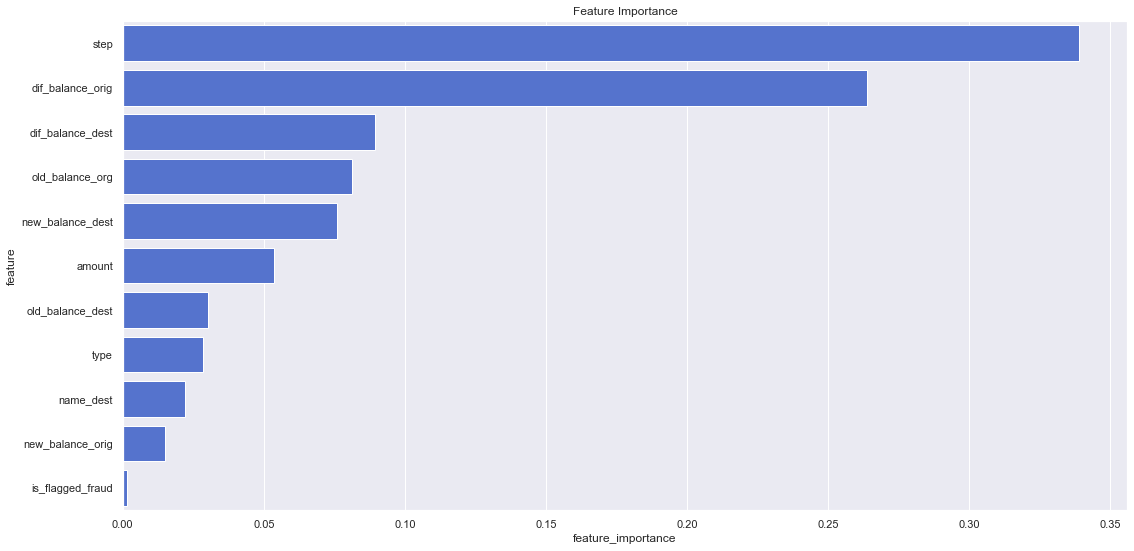

In [57]:
for i,v in enumerate(importance):
    ('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
feature_importance = pd.DataFrame({'feature':X_train.columns,
                                  'feature_importance':importance}).sort_values('feature_importance', ascending=False).reset_index()
sns.barplot(x='feature_importance', y='feature', data=feature_importance, orient='h', color='royalblue').set_title('Feature Importance');

In [60]:
cols_selected = ['step', 'dif_balance_orig', 'dif_balance_dest','old_balance_org','new_balance_dest', 'amount']

# 7.0 Machine Learning Modeling

In [61]:
X_train = X_train[cols_selected]
X_valid = X_valid[cols_selected]

## 7.1 Baseline Model

In [62]:
from sklearn.dummy import DummyClassifier

In [93]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
pred = dummy.predict(X_valid)

### Results

In [94]:
dummy_result = ml_metrics('dummy', y_valid, pred)
dummy_result

,Balanced Accuracy,Precision,Recall,F1
dummy,0.500,0.000,0.000,0.000


### Cross Validation

In [95]:
dummy_result_cv = cross_validation('Dummy_CV', DummyClassifier(), X_train, y_train)
dummy_result_cv

,Balanced Accuracy,Precision,Recall,F1
Dummy_CV,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0


## 7.2 Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegression

In [96]:
lg = LogisticRegression(class_weight='balanced')
lg.fit(X_train, y_train)
pred = lg.predict(X_valid)

### Results

In [97]:
logistic_regression_result = ml_metrics('LogisticRegression', y_valid, pred)
logistic_regression_result

,Balanced Accuracy,Precision,Recall,F1
LogisticRegression,0.930,0.040,0.890,0.070


### Cross Validation

In [98]:
logistic_regression_result_cv = cross_validation('LogisticRegression_CV', LogisticRegression(class_weight='balanced'), X_train, y_train)
logistic_regression_result_cv

,Balanced Accuracy,Precision,Recall,F1
LogisticRegression_CV,0.93 +/- 0.01,0.04 +/- 0.0,0.89 +/- 0.02,0.07 +/- 0.0


## 7.3 KNN

In [99]:
from sklearn.neighbors import KNeighborsClassifier

In [100]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
pred = knn.predict(X_valid)

### Results

In [101]:
knn_result = ml_metrics('KNN', y_valid, pred)
knn_result

,Balanced Accuracy,Precision,Recall,F1
KNN,0.810,0.800,0.620,0.700


### Cross Validation

In [102]:
knn_result_cv = cross_validation('KNN_CV', KNeighborsClassifier(), X_train, y_train)
knn_result_cv

,Balanced Accuracy,Precision,Recall,F1
KNN_CV,0.78 +/- 0.01,0.8 +/- 0.02,0.57 +/- 0.02,0.66 +/- 0.01


## 7.4 ADA Boosting

In [74]:
from sklearn.ensemble import AdaBoostClassifier

In [103]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
pred = ada.predict(X_valid)

### Results

In [104]:
ada_result = ml_metrics('AdaBoost', y_valid, pred)
ada_result

,Balanced Accuracy,Precision,Recall,F1
AdaBoost,0.730,0.900,0.450,0.600


### Cross Validation

In [105]:
ada_result_cv = cross_validation('AdaBoost_CV', AdaBoostClassifier(), X_train, y_train)
ada_result_cv

,Balanced Accuracy,Precision,Recall,F1
AdaBoost_CV,0.84 +/- 0.01,0.94 +/- 0.02,0.68 +/- 0.03,0.79 +/- 0.02


## 7.5 LightGBM

In [78]:
from lightgbm import LGBMClassifier 

In [106]:
lgb = LGBMClassifier(objective='binary', class_weight='balanced')
lgb.fit(X_train, y_train)
pred = lgb.predict(X_valid)

### Results

In [107]:
lgbm_result = ml_metrics('LightGBM', y_valid, pred)
lgbm_result

,Balanced Accuracy,Precision,Recall,F1
LightGBM,0.960,0.260,0.930,0.410


### Cross Validation

In [108]:
lgbm_result_cv = cross_validation('LightGBM_CV', LGBMClassifier(objective='binary', class_weight='balanced'), X_train, y_train)
lgbm_result_cv

,Balanced Accuracy,Precision,Recall,F1
LightGBM_CV,0.94 +/- 0.01,0.31 +/- 0.02,0.89 +/- 0.03,0.46 +/- 0.02


## 7.6 Random Forest

In [82]:
from sklearn.ensemble import RandomForestClassifier

In [109]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)
pred = rf.predict(X_valid)

### Results

In [110]:
rf_result = ml_metrics('Random Forest', y_valid, pred)
rf_result

,Balanced Accuracy,Precision,Recall,F1
Random Forest,0.840,0.950,0.670,0.790


### Cross Validation

In [111]:
rf_result_cv = cross_validation('Random Forest CV', RandomForestClassifier(class_weight='balanced'), X_train, y_train)
rf_result_cv

,Balanced Accuracy,Precision,Recall,F1
Random Forest CV,0.87 +/- 0.01,0.97 +/- 0.01,0.75 +/- 0.01,0.84 +/- 0.01


## 7.7 XGBoost

In [86]:
from xgboost import XGBClassifier

In [112]:
xgb = XGBClassifier(objective='binary:logistic', verbosity=0)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_valid)

### Results

In [113]:
xgb_result = ml_metrics('XGBoost', y_valid, pred)
xgb_result

,Balanced Accuracy,Precision,Recall,F1
XGBoost,0.840,0.930,0.680,0.790


### Cross Validation

In [114]:
xgb_result_cv = cross_validation('XGBoost_CV', XGBClassifier(objective='binary:logistic', verbosity=0), X_train, y_train)
xgb_result_cv

,Balanced Accuracy,Precision,Recall,F1
XGBoost_CV,0.89 +/- 0.01,0.96 +/- 0.02,0.78 +/- 0.02,0.86 +/- 0.02


## 7.8 Results

In [115]:
df_results = pd.concat([dummy_result, logistic_regression_result, knn_result, lgbm_result, ada_result, rf_result, xgb_result])
df_results.style.highlight_max(color='lightgreen', axis=0)

,Balanced Accuracy,Precision,Recall,F1
dummy,0.500000,0.000000,0.000000,0.000000
LogisticRegression,0.930000,0.040000,0.890000,0.070000
KNN,0.810000,0.800000,0.620000,0.700000
LightGBM,0.960000,0.260000,0.930000,0.410000
AdaBoost,0.730000,0.900000,0.450000,0.600000
Random Forest,0.840000,0.950000,0.670000,0.790000
XGBoost,0.840000,0.930000,0.680000,0.790000


### Cross Validation Results

In [116]:
df_results_cv = pd.concat([dummy_result_cv, logistic_regression_result_cv, knn_result_cv, lgbm_result_cv, ada_result_cv, rf_result_cv, xgb_result_cv])
df_results_cv

,Balanced Accuracy,Precision,Recall,F1
Dummy_CV,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0
LogisticRegression_CV,0.93 +/- 0.01,0.04 +/- 0.0,0.89 +/- 0.02,0.07 +/- 0.0
KNN_CV,0.78 +/- 0.01,0.8 +/- 0.02,0.57 +/- 0.02,0.66 +/- 0.01
LightGBM_CV,0.94 +/- 0.01,0.31 +/- 0.02,0.89 +/- 0.03,0.46 +/- 0.02
AdaBoost_CV,0.84 +/- 0.01,0.94 +/- 0.02,0.68 +/- 0.03,0.79 +/- 0.02
Random Forest CV,0.87 +/- 0.01,0.97 +/- 0.01,0.75 +/- 0.01,0.84 +/- 0.01
XGBoost_CV,0.89 +/- 0.01,0.96 +/- 0.02,0.78 +/- 0.02,0.86 +/- 0.02


# 8.0 Hyperparameter Fine Tuning

# 9.0 Conlclusions

# 10.0 Deploy